In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
import plotly.express as px

In [2]:
x = pd.read_csv("TRACKS/collecte_19580_97.csv", sep=";")
y = pd.read_csv("TRACKS/collecte_19582_97.csv", sep=";")
x.head()

date        lat         lon        ut        vt        us  \
0  02/07/1997, 12:00:00  29.391317  196.555016 -0.104871 -0.206097 -0.189328   
1  02/08/1997, 12:00:00  29.159618  196.515431 -0.220875 -0.186884 -0.082064   
2  02/09/1997, 12:00:00  29.100895  196.162572 -0.337656 -0.079462 -0.335119   
3  02/10/1997, 12:00:00  29.036132  195.915601 -0.312440  0.039398 -0.204568   
4  02/11/1997, 12:00:00  29.162120  195.607475 -0.291714  0.167390 -0.436870   

         vs        uc        vc          T  ...  NPP25o  NPP25s  NPP50n  \
0 -0.150640  0.084457 -0.055456  18.156185  ...     NaN     NaN     NaN   
1 -0.206839 -0.138812  0.019955  18.269433  ...     NaN     NaN     NaN   
2 -0.078587 -0.002537 -0.000875  18.144409  ...     NaN     NaN     NaN   
3  0.033753 -0.107872  0.005645  18.291210  ...     NaN     NaN     NaN   
4 -0.014122  0.145156  0.181512  18.742774  ...     NaN     NaN     NaN   

   NPP50e  NPP50o  NPP50s  NPP100n  NPP100e  NPP100o  NPP100s  
0     NaN     NaN     NaN      NaN      NaN      NaN      NaN  
1     NaN     NaN     NaN      NaN      NaN      NaN      NaN  
2     NaN     NaN     NaN      NaN      NaN      NaN      NaN  
3     NaN     NaN     NaN      NaN      NaN      NaN      NaN  
4     NaN     NaN     NaN      NaN      NaN      NaN      NaN  

[5 rows x 78 columns]

In [3]:
figx = px.line_geo(x, lat='lat', lon='lon')
figy = px.line_geo(y, lat='lat', lon='lon')
figx.add_trace(figy.data[0])
figx.update_geos(fitbounds="locations",oceancolor="LightBlue",showocean=True,showland=True, landcolor="LightGreen")
figx.update_layout(height=300, margin={"r":10,"t":10,"l":10,"b":10})
figx.show()

### Recherche

In [4]:
data_dir = ''
track_dir = data_dir + 'TRACKS/'
datafile = data_dir + 'METADATA.csv'

In [5]:
from datetime import timedelta, datetime

def recup_id_batch(num_batch):
    """
    num_batch: batch number (from 1 to 10) or list of batches or 'all'.
    Return turtles id of the wanted batch.
    """
    liste_id = []
    file = open(datafile)
    df = pd.read_csv(file, index_col = 0)
    if type(num_batch) == int:
        num_batch = [num_batch]
    elif num_batch == 'all':
        num_batch = np.arange(1,11)
    for b in num_batch:
        if b not in range(1,11):
            raise ValueError("Batch has to be between 1 and 10 but it is %f"%b)
        else:
            liste_id += list(df['id'][b])
    file.close()
    return np.array(liste_id)

def define_start_end(list_id):
    """
    Return day of release and last day of transmition of each turtle (list of timestamp).
    """
    first_date = []
    last_date = []
    for i in range(len(list_id)):
        id = list_id[i]
        file = track_dir + "/collecte_"  + id + ".csv"
        df = pd.read_csv(file, sep=';')
        date = pd.to_datetime(df["date"])
        first_date.append(date[0])
        last_date.append(date[date.index[-1]])
        
    return first_date, last_date

def insert_nan(nb_before, nb_after, array, lenght, order):
    """
    Insert nb_before nan at the beginning of array and nb_after at the end of array.
    array: 1D array
    """
    array_nan = np.nan * np.ones(lenght)
    if order:
        if nb_after != 0:
            array_nan[nb_before:-nb_after] = array[:]
        else:
            array_nan[nb_before:] = array[:]
    else:
        array_nan[:len(array)] = array[:]
    return array_nan

def select_longitudes(batch, lon_min, lon_max):
    """
    Remove positions for which longitude is not in [lon_min, lon_max].
    """
    condition = (batch['lon'] < lon_min) | (batch['lon'] > lon_max)
    positions_out = np.sum(condition)
    print('\n Removed positions out of longitude range, i.e. %d positions'%positions_out)
        
    for key in batch.keys():
        if key not in ['time', 'id', 'nturtles']:
            batch[key] = np.where(condition, np.nan, batch[key])
        
    return batch    

def remove_neritic(batch, min_depth):
    """
    Remove positions for which depth is less than min_depth meters (positive value).
    """
    if min_depth != 0:
        if min_depth < 0:
            raise ValueError('min_depth has to be positive')
        if min_depth > 0 and 'bathy' not in batch.keys():
            raise ValueError('Add bathy to batch variables')
        
        neritic_pos = np.sum(batch['bathy'] > -min_depth)
        print('\n Removed positions where depth is less than %d m, i.e. %d positions \n'%(min_depth, neritic_pos))
            
        for key in batch.keys():
            if key not in ['time', 'id', 'nturtles']:
                batch[key] = np.where(batch['bathy'] > -min_depth, np.nan, batch[key])
        

    return batch

def get_batch(list_id, variables=['lon', 'lat'], order=True, rm_days=10, min_depth=300, lon_min=130, lon_max=250):
    """
    Create a dictionnary which keys are: id (1D-array), time (1D-array), nb_turtles (1D-array), variables (2D-arrays).
    Each variable is the size (nturtles, max(date) - min(date) + 1)
    If order=True, the first dimension of variables is the date whereas if order=False, the first dimension of variables 
    is the time after release. In case order=True, 'nan' are inserted when there is no value for a given date.
    Parameters:
        -list_id: list of id to load
        -variables: list of variables to load
        -rm_days: int, to remove first days after release
        -min_depth: float, positive, remove positions where bathymetry is less than min_depth meters
        -lon_min/lon_max: minimum and maximum longitudes
    """
    
    keys = ['id', 'time', 'nturtles'] + variables
    variables.append('lon')
    if min_depth > 0:
        variables.append('bathy')
    batch = {}.fromkeys(keys)
    #
    batch['id'] = list_id
    first_date, last_date = define_start_end(list_id)
    t0 = np.min(first_date)
    t1 = np.max(last_date)
    nb_days = (t1 - t0).days + 1
    nb_turtles = len(list_id)
    #
    batch['time'] = t0 + timedelta(days=1) * np.arange(nb_days)  
    #
    tot_pos = 0
    if variables != []:
        for var in variables:
            batch[var] = np.zeros((nb_days, nb_turtles))        
        
        for i in range(nb_turtles):
            id = list_id[i]
            nb_before = (first_date[i] - t0).days
            nb_after = (t1 - last_date[i]).days
            file = track_dir + "/collecte_"  + id + ".csv"
            df = pd.read_csv(file, sep=';')
            for var in variables:
                array = np.array(df[var])
                if var == variables[0]:
                    tot_pos += len(array) # count number of positions
                array[:rm_days] = np.nan  # remove first days
                array = insert_nan(nb_before, nb_after, array, nb_days, order)
                batch[var][:, i] = array
    
        # Number of turtles
        batch['nturtles'] = np.zeros(nb_days)
        for t in range(nb_days):
            arr = batch[variables[0]][t,:]
            batch['nturtles'][t] = np.count_nonzero(~np.isnan(arr))
    if rm_days > 0:
        if 'lat' in batch.keys():
            nb_pos = np.sum(~np.isnan(batch['lat']))
            print('\n Removed %d first days, i.e. %d of %d positions'%(rm_days, tot_pos-nb_pos, tot_pos))
    batch = select_longitudes(batch, lon_min, lon_max)
    batch = remove_neritic(batch, min_depth)
    return batch

In [21]:
list_id = recup_id_batch('all')
extract = get_batch(list_id, variables=['T'], order=False)


 Removed positions out of longitude range, i.e. 0 positions

 Removed positions where depth is less than 300 m, i.e. 265 positions 



In [22]:
extract.keys()

dict_keys(['id', 'time', 'nturtles', 'T', 'lon', 'bathy'])

In [23]:
extract['T'].shape

(6142, 231)

In [49]:
def nonan(mat_transpose):
    return [list(filter(lambda x: str(x) != 'nan', turtle)) for turtle in mat_transpose]

In [52]:
temp = nonan(np.transpose(extract['T']))
lon = nonan(np.transpose(extract['lon']))

In [55]:
px.scatter(x=lon[1], y=temp[1])

In [35]:
T = [x for x in extract['T'] if str(x) != 'nan']

In [47]:
T_nonan = [[x for x in row if str(x) != 'nan'] for row in np.transpose(extract['T'])]

In [48]:
T_nonan

[[18.515175201698735,
  18.575779246052846,
  18.863727473751183,
  18.755919591519245,
  18.589395570465893,
  17.18678379148568,
  17.005323421281858,
  16.789809440886465,
  16.763005393263906,
  16.973490655894576,
  17.310332454342067,
  17.621086665966754,
  17.608514633969946,
  17.430327876376975,
  16.995380562391645,
  16.686821592805266,
  17.055273861789672,
  17.057734842956272,
  17.00086268382329,
  16.790674059380382,
  16.852366761079224,
  16.701318821920314,
  17.350948566719673,
  17.246693193377464,
  17.481328494464883,
  17.273903321736878,
  17.38896010815947,
  16.951144725499912,
  16.785242132979786,
  17.07078816186997,
  17.243156588323515,
  16.989175537650482,
  17.163118176105574,
  17.02084918211183,
  16.89060483600942,
  16.686103665760086,
  16.609420376210892,
  16.619684483995595],
 [17.945661622643033,
  17.318535261630267,
  18.415862799675367,
  18.687672636986488,
  18.47995128336992,
  18.56094029287877,
  16.823783564653745,
  17.001268718582

In [36]:
T_0 = [row[0] for row in T]

In [37]:
T_0

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 18.515175201698735,
 18.575779246052846,
 18.863727473751183,
 18.755919591519245,
 18.589395570465893,
 17.18678379148568,
 17.005323421281858,
 16.789809440886465,
 16.763005393263906,
 16.973490655894576,
 17.310332454342067,
 17.621086665966754,
 17.608514633969946,
 17.430327876376975,
 16.995380562391645,
 16.686821592805266,
 17.055273861789672,
 17.057734842956272,
 17.00086268382329,
 16.790674059380382,
 16.852366761079224,
 16.701318821920314,
 17.350948566719673,
 17.246693193377464,
 17.481328494464883,
 17.273903321736878,
 17.38896010815947,
 16.951144725499912,
 16.785242132979786,
 17.07078816186997,
 17.243156588323515,
 16.989175537650482,
 17.163118176105574,
 17.02084918211183,
 16.89060483600942,
 16.686103665760086,
 16.609420376210892,
 16.619684483995595,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [14]:
T = [row[0] for row in extract['T']]

In [20]:
len(T)

6142

In [34]:
px.scatter(y=T_0)

In [26]:
lon_lat.keys()

dict_keys(['id', 'time', 'nturtles', 'lon', 'lat', 'bathy'])

In [30]:
order = list(lon_lat['id']).index('22279_10')

197

In [60]:
lon_lat['lon'].shape

(6142, 231)

In [65]:
lon = [row[4] for row in lon_lat['lon']]

In [66]:
lon

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 200.48567914893903,
 200.54576435822202,
 200.62642386502705,
 200.684065659792,
 200.75735960767602,
 201.06389834053797,
 201.34271825785999,
 201.513033589153,
 201.60140924121004,
 201.708262857882,
 201.80744600371398,
 201.916023901544,
 202.00797364501702,
 202.101331857318,
 202.173121213237,
 202.25445566155497,
 202.355154457265,
 202.539113592356,
 202.845275088054,
 203.205444980546,
 203.55346874215198,
 203.57494474312,
 203.49549115185002,
 203.350889074832,
 203.21585778251202,
 202.97971821652501,
 203.05189313942,
 202.833631051203,
 202.52265447180

In [57]:
lon_lat['lon'][197]

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan, 179.15280483,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

In [32]:
len(list(lon_lat['lon']))

6142

### Draft

NameError: name 'lonx' is not defined

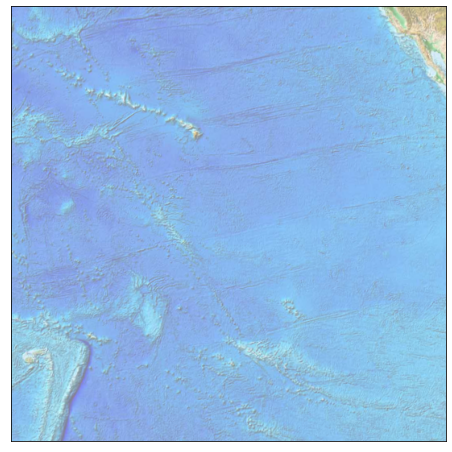

In [4]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=5, lon_0=210,)
m.etopo(scale=0.5, alpha=0.5)

for i_lon, i_lat in zip(lonx, latx) :
    x, y = m(i_lon, i_lat)
    plt.plot(x, y, 'ok', markersize=2)

for i_lon, i_lat in zip(lony, laty) :
    x, y = m(i_lon, i_lat)
    plt.plot(x, y, 'ok', markersize=2)

In [ ]:
latx = x['lat'].values
lonx = x['lon'].values

laty = y['lat'].values
lony = y['lon'].values

In [14]:
path = 'TRACKS/'
nb_turtles = len(os.listdir(path))

In [31]:
def id_extract(file_name):
    sep = file_name[:-4].split('_')[1:]
    return str(sep[0]) + '_' + str(sep[1])

In [51]:
def geo_extract(path=path, nb=5):
    data_geo = {}
    
    files = os.listdir(path)
    for file in files[:nb]:
        id_turtle = id_extract(file)
        x = pd.read_csv(path + file, sep=';')
        lat = list(x['lat'].values)
        lon = list(x['lon'].values)
        #data_geo[id_turtle] = [lon, lat]
        df = pd.DataFrame(id_turtle)
        df['lon'] = lon
        df['lat'] = lat
    return df

In [20]:
#x = geo_extract()
#pd.DataFrame

In [ ]:
fig = px.line_geo(x, lat='lat', lon='lon' )
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":10,"t":10,"l":10,"b":10})
fig.show()